# Feature Selection

##  Методы фильтрации признаков.
Методы отбора признаков делятся на 3 группы:
* `Filter methods`
* `Wrapper methods`
* `Embedded methods`

<div class="alert alert-info">    
    
## 🎓 Filter methods (методы фильтрации)
    
Эти методы основаны на статистических методах и, как правило, рассматривают каждый признак независимо. Позволяют оценить и ранжировать фичи по значимости, за которую принимается степень корреляции этой фичи с целевой переменной. Основное преимущество этой группы методов - низкая цена вычислений, которая линейно зависит от общего количества признаков.  Они значительно быстрее и `wrapper` и `embedded` методов. К тому же, они хорошо работают даже тогда, когда число признаков превышает количество примеров в обучающей выборке (чем далеко не всегда могут похвастаться методы других категорий). <br>
Основной недостаток этих методов состоит в том, что они рассматривают каждый признак изолированно от других, поэтому они не такие точные, но могут быстро отранжировать признаки. Правда прогресс не стоит на месте и появляются filter методы, которые пытаются решить эту проблему разными способами - на основе взаимной информации признаков, или учитывая избыточность признаков (метод `mRmR`  - минимальная избыточность при максимальной релевантности).<br>
Некоторые из таких методов реализованы в разделе `sklearn.feature_selection` библиотеки `scikit-learn` - например, `SelectKBest`, `chi2` и пр. Также `feature importance` в библиотеках градиентых бустингов, можно сказать, основаны на этой методике, но в той же мере их можно отнести и к встроенным методам - дискуссионный вопрос.

<div class="alert alert-info">    

## 🧩 Embedded methods (встроенные методы)
    
Куда же они встроены? А прямо в процесс обучения модели. Эти модели позволяют не разделять процессы тренировки и отбора признаков, т.е. во время обучения модели проводить отсев и на выходе получить модель, которая знает на какие признаки обращать больше внимания, а какие мусор. Эти методы требуют меньше вычислений, чем `wrapper` методы, но больше, чем методы фильтрации. Как вы уже, наверное, догадались, основными методами из этой группы являются наши "старые знакомые" - регуляризации (например, `LASSO-` и `Ridge-` регрессии), алгоритмы `DecisionTree` и `RandomForest`, свои регуляризации есть также в бустингах и нейросетях.<br>
Минусы у регуляризаций тоже есть: хотя бы раз придется обучить модель на всех признаках и посмотреть коэффициенты, что не всегда удобно и осуществимо. Также обученная на всех признаках модель медленнее будет работать при инференсе. Но в общем случае этот метод способен лучше уловить взаимозависимости переменных, чем методы фильтрации.

<div class="alert alert-info">    
    
## 🧠 Wrapper methods (оборачивающие методы, методы-обертки?? не понятно как лучше перевести - пишите свои варианты в комментарии)
Что же они заворачивают\оборачивают? А оборачивают они обучение модели в последовательное удаление (`backward feature selection`) или добавление (`forward feature selection`) признаков. `Backward feature selection` лучше отслеживает взаимосвязи между фичами, но он гораздо дороже вычислительно.<br>
Основной недостаток всех `wrapper` методов - это долгое время вычислений. К тому же, в случае большого количества признаков и небольшого размера тренировочного датасета, эти методы имеют опасность переобучения.<br>
Примеры таких методов: `RFE (recursive feature elimination)` из библиотеки `scikit-learn`, `Boruta` из пакета `BorutaPy` (для алгоритма `RandomForest`) и др.<br>

<div class="alert alert-info">    
    
🤔 Порой бывает трудно однозначно определить к какой группе относится тот или иной метод или это вообще гибрид, который сочетает в себе несколько методов. Например, при использовании библиотеки градиентного бустинга `CatBoost` можно потрогать методы всех 3-х типов или их сочетания: если взять просто `feature importance` c дефолтными параметрами и отключенной регуляризацией, то получим `filter` метод. Если добавим в модель параметры, отвечающие за регуляризацию, то получим своеобразный гибрид - вроде `filter` метод, но вместе с тем с регуляризацией (`embedded` метод). Если применим встроенную в CatBoost функцию `feature_selection()`, то будет работать `wrapper` метод с `backward feature selection`.<br>
<br>

In [1]:
!pip install catboost shap -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
# Загружаем датасет из quickstart'а

df = pd.read_csv('quickstart_train.csv')
df.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


In [4]:
df.deviation_normal_count.value_counts()

deviation_normal_count
174    2337
Name: count, dtype: int64

# Что можно сразу удалить? 

<div class="alert alert-info">
    
* Константы
* Уникальные значения (в том числе в тесте, как правило это ID-шники по типу `car_id`)

In [5]:
cols2drop = ['car_id', 'deviation_normal_count']
df.drop(cols2drop, axis=1, inplace=True, errors = 'ignore')

#  Добавим рандомные признаки в датасет

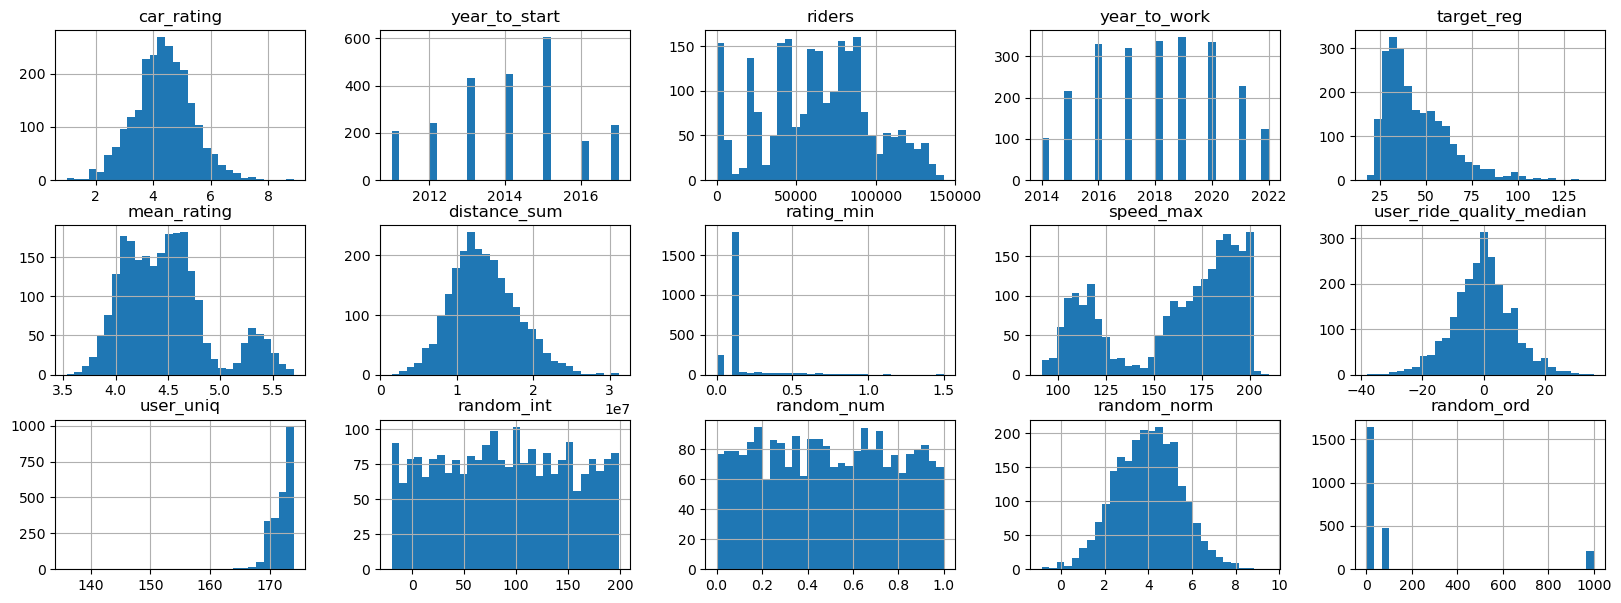

In [8]:
df['random_int'] = np.random.randint(-20, 200, df.shape[0]) # Целочисленный признак
df['random_num'] = np.random.random(size = df.shape[0]) # Признак типа float с равномерным распределением
df['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = df.shape[0]) # Признак с нормальным распределением
df['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], size = df.shape[0]) # Категориальный признак str формата с дисбалансом
df['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], size = df.shape[0]) # Численный категориальный признак

df.hist(figsize = (20, 7), layout = (-1, 5), bins=30);

# Линейная корреляция

In [9]:
corrs = df.dropna().corr().round(3).sort_values('target_reg')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

ValueError: could not convert string to float: 'Kia Rio X-line'

**Преимущества и недостатки фильтрации по корреляции?**

* ✅ Быстро и понятно
* ❌ Не улавливает нелинейные зависимости
* ❌ Упускает парные зависимости
* ❌ Не подходит для категорий (нужен другой стат. критерий)


# Phik


In [10]:
!pip install phik -q

In [11]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq', 'random_int', 'random_num', 'random_norm', 'random_ord']


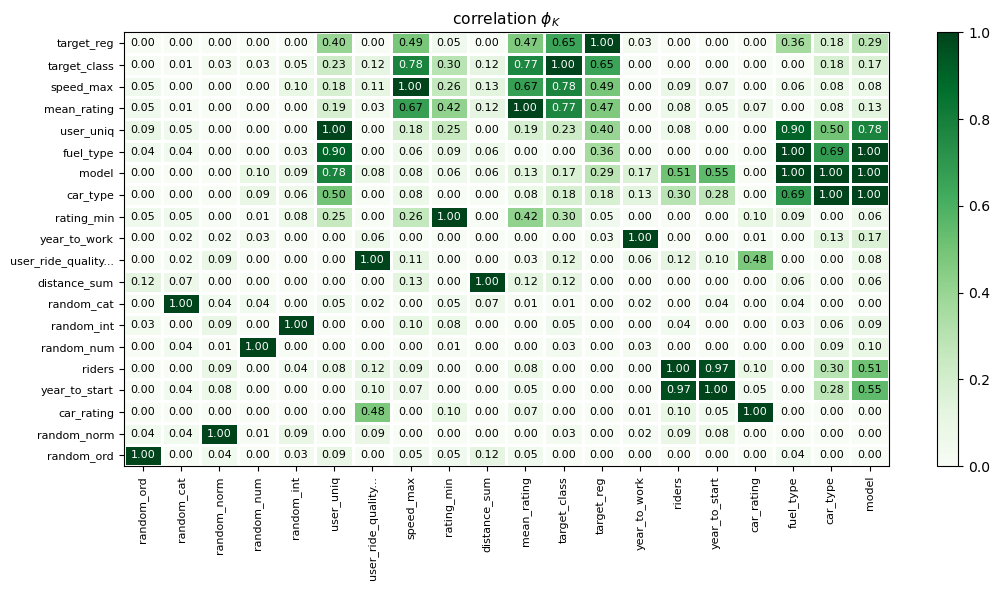

In [12]:
phik_overview = df.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq', 'random_int', 'random_num', 'random_norm', 'random_ord']


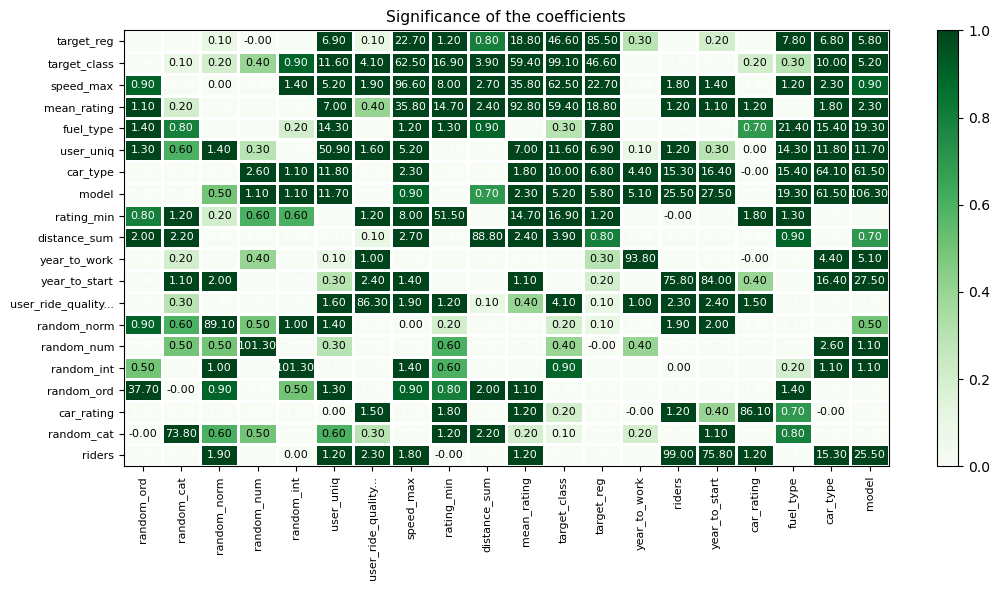

In [13]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

__Интерпретация логарифмической вероятности__

Если логарифмическая вероятность вашего результата больше 6.63, вероятность того, что результат, произойдет случайно, составляет менее 1%. Таким образом, мы можем быть на 99% уверены, что результат действительно что-то значит. В терминах `p-value` обычно это выражается как `p < 0.01`. Если логарифмическая вероятность составляет 3.84 или более, вероятность того, что это произойдет случайно, составляет менее 5%. Так что мы на 95% уверены в результате. В терминах `p-value` это выражается как `p < 0.05`.


**Преимущества и недостатки метода `phik`?**

* ✅ Работает с категориальными значениями!
* ✅ Ловит нелинейные зависимости!
* ❌ Не ловит парные зависимости
* ❌ Долго считается, если много признаков

## <center>Feature Importance - полезно, но легко подскользнуться 🍌 </center>

    
<p id="g1"></p> 

<div class="alert alert-info">
    
Для примера возьмем библиотеку градиентного бустинга `CatBoost`.

In [14]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [15]:
drop_cols = ['car_id', 'target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model', 'random_cat']

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target_class'].fillna(0)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.8563325	test: 1.8674589	best: 1.8674589 (0)	total: 135ms	remaining: 2m 15s
100:	learn: 0.3990246	test: 0.5604390	best: 0.5602855 (99)	total: 8.88s	remaining: 1m 19s
200:	learn: 0.2746356	test: 0.5508146	best: 0.5498226 (139)	total: 18.2s	remaining: 1m 12s
300:	learn: 0.1964419	test: 0.5514641	best: 0.5484263 (240)	total: 28.1s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5484263414
bestIteration = 240

Shrink model to first 241 iterations.


In [18]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,35.352384
1,mean_rating,30.523543
2,rating_min,12.345828
3,model,3.015072
4,user_uniq,2.892301
5,car_type,2.528062
6,random_cat,2.086526
7,user_ride_quality_median,1.808450
8,random_num,1.447287
9,distance_sum,1.443001


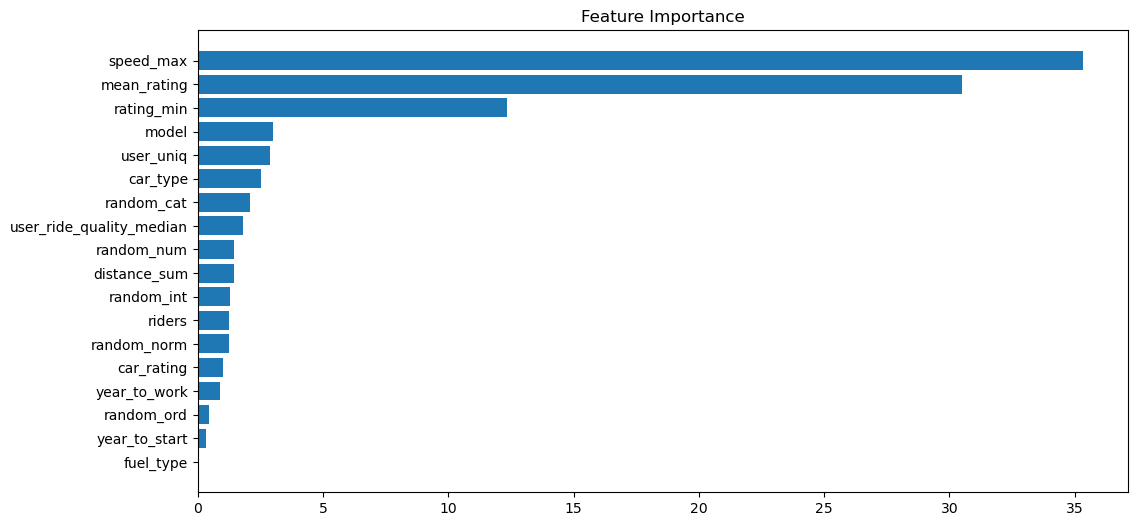

In [19]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

<div class="alert alert-info">
    
⚠️ Найденный топ фичей далеко не всегда будет подмножеством, на котором модель покажет наилучшую точность. Если взять `feature importance`, обучив модель бустинга 1 раз, при наличии большого числа сильноскоррелированных признаков они поделят importance между собой (т.к. дерево выберет не одну из них, а все, а частота выбора маленькая) и упадут вниз в топе по важности. Далее если мы возьмем топ-N, то мы их обрежем, а в топе останется мусор.

#  Permutation importance 

<div class="alert alert-info">

    
🍏 `Permutation Importance` из библиотеки `scikit-learn` произвольным образом перетасовывает значения в одном столбце из датасета валидации, оставив все остальные столбцы нетронутыми. Признак считается «важным», если точность модели падает и его изменение вызывает увеличение ошибок. С другой стороны, признак считается «неважным», если перетасовка его значений не влияет на точность модели. <br>
    
  

<div class="alert alert-info">

⚠️  В оценке важности признаков таким способом кроется много подводных камней. Например, признак **A** присутствует лишь в небольшой доле объектов, но сильно влияет на результат, тогда как признак **B** оказывает лишь небольшое влияние на результат, но во всех объектах. Оба этих признака важны, но эта важность разного рода, и в стандартных методах оценки важности признаков не будет видно этого различия.

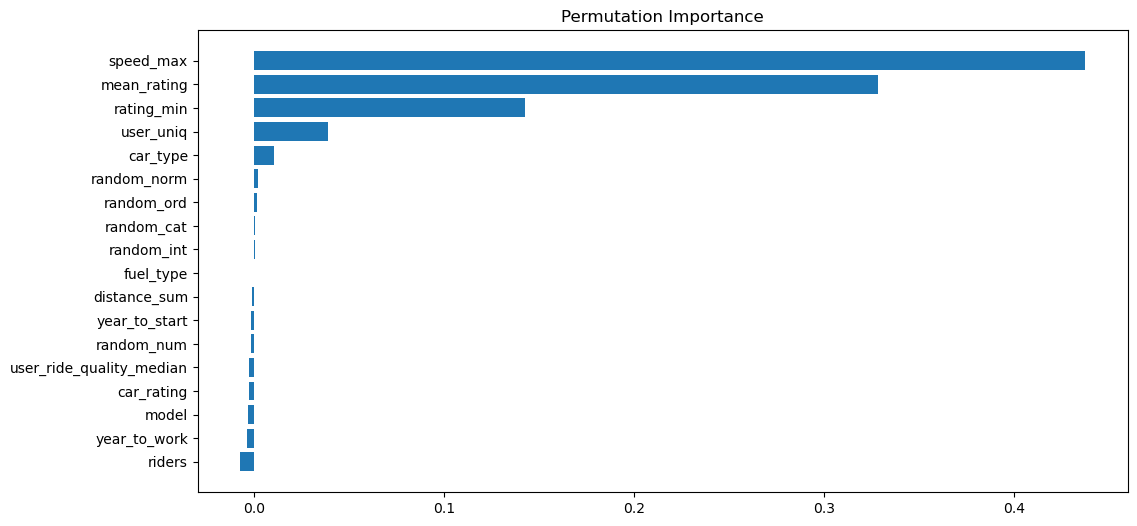

In [20]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

<div class="alert alert-info">
    
⚠️ Важность признаков может сильно зависеть от особенностей распределения данных, а это распределение может отличаться при обучении и инференсе. Эта особенность добавляет неоднозначности понятию важности признака.

**Можно ли рандомные признаки использовать как границу для отсеивания ?**

<div class="alert alert-info">
    
Как можем видеть, и в импортансе катбуста и в импортансе пермутэйшена рандомный признак попал в топ-10 рейтинга. Следовательно, всё, что ниже, можно считать шумом и откидывать. Интересно, что признак `model` оказался ниже рандома, хотя в других рейтингах находился достаточно высоко.
    
    
🧠 В общем, **ответ - да, можно**, но нет гарантий, что даст улучшение. Можно случайно выбрость полезные признаки. Надо проверять валидацией! 

<div class="alert alert-info">
    
Переобученная модель может давать, в целом, неверную важность признаков. Если релевантность признаков заранее известна, то это может помочь распознать переобучение, но если релевантность заранее неизвестна, то отбор признаков на основе важности может в этом случае только усилить переобучение.

## SHAP values

<div class="alert alert-info">
    
Более современным способом оценки важности признаков являются `SHAP values`, основанные на теории игр, позволяют оценить важность признаков на конкретном тестовом примере. `SHAP values` тоже имеют некоторые проблемы: они зависят от распределения данных, то есть являются характеристикой не только модели, но объединенной системы "модель + распределение данных". При этом можно получить ненулевые SHAP values для тех признаков, которые никак не используются моделью.

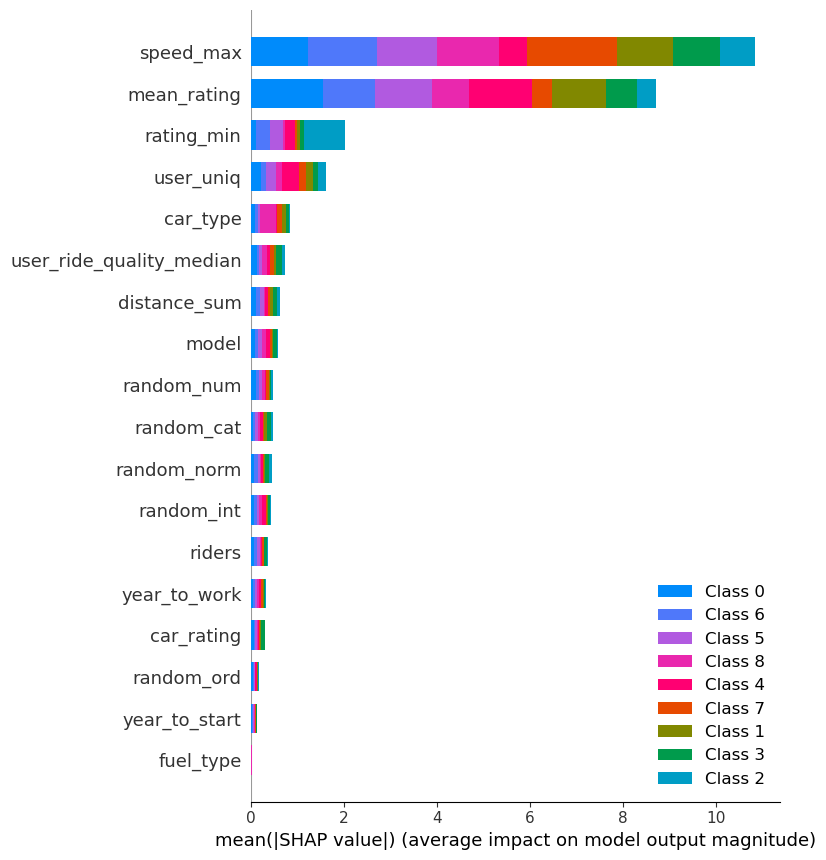

In [21]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

Более подробно про библитеку SHAP будет расказано в следующем уроке про визуализацию.

## CatBoost Feature Selection (рекурсивные методы)

    

**Суть рекурсивных алгоритмов: удаляем признаки и смотрим, уменьшится ли качество. Если уменьшилось, значит признак вредный**    
        
В библиотеке `CatBoost` есть встроенный метод для отбора признаков [select_features](https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features), который поддерживает 3 алгоритма отбора признаков - параметр `algorithm`:
* `RecursiveByPredictionValuesChange` - самый быстрый и достаточно точный
* `RecursiveByLossFunctionChange` - оптимальный по соотношению точность/скорость
* `RecursiveByShapValues` (по умолчанию) - наиболее точный, но самый ресурсозатратный <br>
Если не хватает времени (ресурсов) на самый точный алгоритм, можно попробовать другие.

In [22]:
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-13',
                      num_features_to_select=8,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

In [23]:
# Посмотрим на список отобранных фичей (не отранжирован по важности)
print(summary['selected_features_names'])
# И на лучшее значение лосса
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['car_type', 'fuel_type', 'car_rating', 'mean_rating', 'rating_min', 'speed_max', 'user_uniq', 'random_int']
Best loss: 0.5414366907364435


In [24]:
# В summary сохраняется полный отчет работы алгоритма
summary

{'selected_features': [1, 2, 3, 7, 9, 10, 12, 13],
 'eliminated_features_names': ['riders',
  'distance_sum',
  'model',
  'year_to_work',
  'year_to_start',
  'user_ride_quality_median'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6],
  'loss_values': [0.5552678473515816,
   0.5498103541525461,
   0.5465729754193633,
   0.544734528826121,
   0.5429978339970378,
   0.5416253977647238,
   0.5414366907364435]},
 'eliminated_features': [5, 8, 0, 6, 4, 11],
 'selected_features_names': ['car_type',
  'fuel_type',
  'car_rating',
  'mean_rating',
  'rating_min',
  'speed_max',
  'user_uniq',
  'random_int']}

<div class="alert alert-info">
    
Видим, что с каждой итерацией отбрасывалось по 1 фиче и точность каждый раз возрастала.

__Ещё из этого же семейства стоит присмотреться к библиотеке [BorutaShap](https://pypi.org/project/BorutaShap/)__ - `wrapper` метод, который сочетает в себе алгоритм `Boruta` и `shapley values`. <br> Показывает неплохую эффективность, правда библиотека не обновлялась с 2020 года.

<!-- hide this -->

# Проверим качество без лишних признаков

In [ ]:
# Давайте возьмем топ-6 самых встречаемых и посмотрим как изменится точность.
important_features = ['speed_max', 'mean_rating', 'rating_min', 'user_uniq', 'user_ride_quality_median', 'car_type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(random_state=42,
                           cat_features=['car_type'],
                           thread_count=-1)


model.fit(X_train[important_features], y_train, 
          eval_set=(X_test[important_features], y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

<div class="alert alert-info">
    
🍏 Функция ошибки снизилась (`0.543 -> 0.521`) . Попробуйте провести свои эксперименты и ещё увеличить точность!